In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import csv
import json
import os 
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import shutil
from importlib import reload
from IPython.display import Image, display, HTML

import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [13]:
import config
import utils

import raw_log_types
import results
import tasks
import task_results
from main import VbsVis

from constants import *

In [14]:
%autoreload 2

In [15]:
VbsVis.flush_cache()
vbs = VbsVis()

vbs.parse_team("SOMHunter", 
                  ["sh-patrik", "sh-vit"], 
                  verbose=True, 
                  validate_fix=False,
                  generate_DRES=False
                 )
# vbs.parse_team("CollageHunter", 
#                   ["collage-jakub", "collage-premek"], 
#                   verbose=True, 
#                   validate_fix=False, 
#                   generate_DRES=False
#                  )
# vbs.parse_team("LegacySOMHunter", 
#                   ["legacy-tereza", "legacy-franta-tomas"], 
#                   verbose=True, 
#                   validate_fix=False, 
#                   generate_DRES=False
#                  )

#VbsVis.help()

Error while deleting directory
%%% PARSING TASKS %%%
%%% Parsed 38 tasks. %%%
%%% DONE! %%%
TEAM: SOMHunter

%%% PARSING %%%
---
+++ sh-patrik +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-vit 

	--- PARSING SUBMITS. ---
	--- DONE. ---
---
+++ sh-patrik +++ 
DATA: ./data/sh-vit 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
---
+++ sh-vit +++ 
DATA: ./data/sh-patrik 

	--- PARSING SUMMARY. ---
	--- DONE. ---
	--- PARSING TASK RESULTS. ---
	--- DONE. ---
%%% DONE! %%%


In [16]:
#VbsVis.cache(vbs)

In [89]:
def plot_timelines(self, tasks=None, teams=None, users=None):      
    
    for t in self.tasks().tasks():
        t_name = t.name()
        if ((tasks != None) and (not (t_name in tasks))):
            continue

        print(f"\t%%% {t_name} %%%")
        
        t_dur = t.duration()
        
        times = {}
        vals_videos = {}
        vals_frames = {}
        
        result_num_limit = {}
        
        keys_corr_submits = {}
        keys_incorr_submits = {}
        submits_indeterminate = {}
        submits_timeout = {}
        submits_server_lag = {}
        submits_logged_out = {}
        
        d_keys = {}
        d_vals = {}
        
        # Flags
        flags = {}
        
        task_results = self.task_results().task_results_arrays()
        user_submits = self.task_results().task_submits_arrays()
        
        for team, team_dict in task_results.items():
            if ((teams != None) and (not (team in teams))):
                continue

            print(f"\t--- {team} ---")

            # User names for this one plot
            this_users = [] 
            
            #
            # Generate array data
            #
            for user, user_results in team_dict.items():
                if ((users != None) and (not (user in users))):
                    continue

                print(f"\t\t--- {user} ---")
                this_users.append(user)

                user_task_results = user_results[t_name]
                user_task_submits = user_submits[team][user][t_name]
                
                # Input data
                times[user] = user_task_results.elapsed()
                vals_videos[user] = user_task_results.vid()
                vals_frames[user] = user_task_results.fr()
                flags[user] = user_task_results.c()
                result_num_limit[user] = user_task_results.reported()

                submits = list(zip(user_task_submits.elapsed(), user_task_submits.c()))
                
                keys_corr_submits[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "T", submits)))
                keys_incorr_submits[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "F", submits)))
                
                submits_indeterminate[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "I", submits)))
                submits_timeout[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "TIMEOUT", submits)))
                submits_server_lag[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "SERVER_LAG", submits)))
                submits_logged_out[user] = list(map(lambda y: y[0], filter(lambda x: x[1] == "LOGGED_OUT", submits)))
                
            # Canvas size
            fig, ax = plt.subplots(figsize=(16,4))

            # Title
            ax.set_title(t_name, y=1.0)

            #ax.yaxis.set_visible(False)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(True)
            ax.xaxis.set_ticks_position('bottom')

            # Set y to log scale
            plt.yscale("log")

            # Set y axis range
            plt.ylim(1, 100000)
            ax.set_xlim(xmin=0, xmax=t_dur + 10)

            iter = 0
            for member_ID in this_users:
                ##########################
                # Draw video & frame pos
                ##########################

                #
                # Get rid of None values for AVS
                #
                vals_videos[member_ID] = list(map(lambda x: x if (x != None) else 1, vals_videos[member_ID]))
                vals_frames[member_ID] = list(map(lambda x: x if (x != None) else 1, vals_frames[member_ID]))

                #
                # Video positions
                #
                plt.step(times[member_ID], vals_videos[member_ID], where='post', label='post', color=COLORS[iter] , linewidth="2")

                #
                # Frame positions
                # (just horizontal lines)
                fst = times[member_ID][:-1]
                snd = times[member_ID][1:]
                ys = vals_frames[member_ID]
                zipped = list(zip(fst, snd, ys))
                rrr = list(filter(lambda x: x[2] < 20000, zipped))

                if len(rrr) != 0:
                    fst, snd, ys = list(zip(*rrr))
                    #plt.step(times[member_ID], vals_frames[member_ID], where='post', label='post', color=COLORS[iter], linestyle=':', linewidth="4")
                    plt.hlines(ys, fst, snd, label='post', color=COLORS[iter], linestyle=':', linewidth=3)

                #
                # Limit of send results
                #
                plt.step(times[member_ID], result_num_limit[member_ID], where='post', label='post', color=COLORS[iter], linestyle='dashdot', linewidth="1")

#                 ##########################
#                 # Draw display switches
#                 ##########################

#                 if (team_ID in task["displays"] and member_ID in task["displays"][team_ID]):
#                     displ_types = task["displays"][team_ID][member_ID][1]

#                     for state in displ_types:
#                         #plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)

#                         if (state.display == "R"):
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_random[member_ID])
#                         elif state.display == "T":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_topn[member_ID])
#                         elif state.display == "N":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_topknn[member_ID])
#                         elif state.display == "S":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_som[member_ID])
#                         elif state.display == "D":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_detail[member_ID])
#                         elif state.display == "P":
#                             plt.plot([state.time], [2000 + member_ID * 1000], **d_marker_replay[member_ID])


                ##########################
                # Draw event markers
                ##########################

#                 iii = 0
#                 for f in flags[member_ID]:

#                     keys = f.keys()
#                     rich = f["is_knn"] or f["is_localized"] or f["is_color"] or f["is_bayes"]or f["is_text"]


#                     if not rich:
#                         cust_marker = {"marker": r"$?$", "markerfacecolor": COLORS[member_ID], "markeredgecolor": COLORS[member_ID], "markersize": 12}
#                         plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **cust_marker)

#                     #
#                     # Is KNN
#                     #
#                     if (f["is_asr"]):
#                         plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **asr_marker)


#                      #
#                     # Is KNN
#                     #
#                     if (f["is_knn"]):
#                         if (f["is_knn"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **knn_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **knn_marker_bkg_red)

#                     #
#                     # Is localized object
#                     #
#                     if (f["is_localized"]):
#                         if (f["is_localized"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **localized_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **localized_marker_bkg_red)
#                     #
#                     # Is color sketch
#                     #
#                     if (f["is_color"]):
#                         if (f["is_color"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **color_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **color_marker_bkg_red)





#                     #
#                     # Is Bayes rerank
#                     #
#                     if (f["is_bayes"]):
#                         if (f["is_bayes"]==1):
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **bayes_marker_bkg)
#                         else:
#                             plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **bayes_marker_bkg_red)

#                     #
#                     # (Temporal) Text query
#                     #
#                     if (f["is_text"]):

#                         if ("text_type" in f and f["text_type"] != None):
#                             label = ""

#                             if f["text_type"]["concept"]:
#                                 label += "C,"

#                             if f["text_type"]["caption"]:
#                                 label += "P,"

#                             if f["text_type"]["ocr"]:
#                                 label += "O,"

#                             if (label != ""):
#                                 cust_marker = {"marker": r"$t$", "markerfacecolor": "#000000", "markeredgecolor": "#000000", "markersize": 12, "label":label}                        
#                                 plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **cust_marker)
#                                 plt.text(times[member_ID][iii] + 2, vals_videos[member_ID][iii], label, fontsize=10)




#                         else:
#                             if (f["is_text"] == 1):
#                                 if (f["is_temporal"]):
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **temp_marker)
#                                 else:
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **text_marker)
#                             else:
#                                 if (f["is_temporal"]):
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **temp_marker_red)
#                                 else:
#                                     plt.plot([times[member_ID][iii]], [vals_videos[member_ID][iii]], **text_marker_red)




#                     iii +=1

                ##########################
                # Draw the end of the task
                ##########################
                plt.axvline(x=t_dur, color='r', linestyle=':', linewidth="10")

                ##########################
                # Draw submits
                ##########################
                
                # Correct
                for s in keys_corr_submits[member_ID]:
                    plt.axvline(x=s, color='g', linewidth="2")

                # Incorrect
                for s in keys_incorr_submits[member_ID]:
                    plt.axvline(x=s, color='darkorange', linewidth="2")
                    
                # Indeterminate
                for s in submits_indeterminate[member_ID]:
                    plt.axvline(x=s, color='grey', linewidth="2")
                    
                # Timeout
                for s in submits_timeout[member_ID]:
                    plt.axvline(x=s, color='r', linewidth="4")
                    
                # Lag
                for s in submits_server_lag[member_ID]:
                    plt.axvline(x=s, color='fuchsia', linewidth="4")
                    
                # Logged out
                for s in submits_logged_out[member_ID]:
                    plt.axvline(x=s, color='b', linewidth="4")
                                   
                iter += 1
            
            #ax.get_yaxis().set_ticklabels([])
            plt.savefig(os.path.join(config.out_dir("timelines"), t_name + ".pdf"))
            plt.show()

            
            
            
        
    #plt.savefig(CONFIG.BASE_DIR + "timelines.png")

In [90]:
vbs.print_task_course(["SOMHunter"], ["sh-patrik"], ["09_a21-7"])

***############################***
***###*** TASK COURSES ***###***
***############################***
--- SOMHunter ---
	--- sh-patrik ---
		--- 09_a21-7 ---

	(!) 6.51 (!)
	action: textQueryChange
	time: 15:11:41
	timestamp: 1624281101849
	values: 

	(!) 7.36 (!)
	action: textQueryChange
	time: 15:11:42
	timestamp: 1624281102702
	values: 

	(!) 8.87 (!)
	action: textQueryChange
	time: 15:11:44
	timestamp: 1624281104210
	values: 

	(!) 10.47 (!)
	action: rescore
	time: 15:11:45
	timestamp: 1624281105808
	values: 

		###!!!### 0.01 ###!!!###
		- REPORT RESULTS -
		- ['TQ'] -
		- (None, None, 9205) -

	(!) 10.73 (!)
	action: reportResults
	time: 15:11:46
	timestamp: 1624281106069
	values: 

	(!) 10.81 (!)
	action: showSomDisplay
	time: 15:11:46
	timestamp: 1624281106145
	values: 

	(!) 18.59 (!)
	action: showTopScoredDisplay
	time: 15:11:53
	timestamp: 1624281113925
	values: 

--->>> 20.25 --->>>
- SUBMIT REQUEST-
- I -

	(!) 20.33 (!)
	action: submit
	time: 15:11:55
	timestamp: 1624281

	%%% 01_v21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


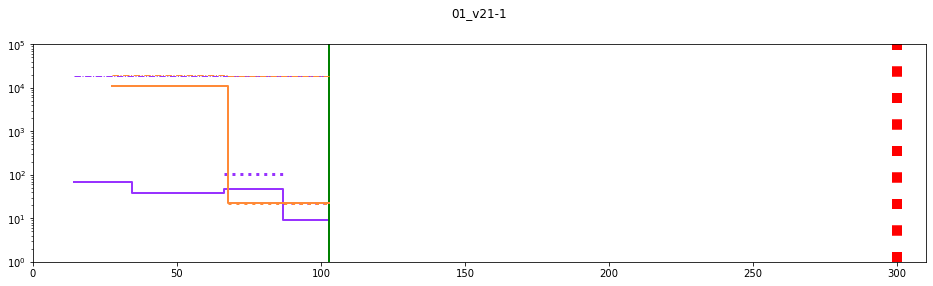

	%%% 02_a21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


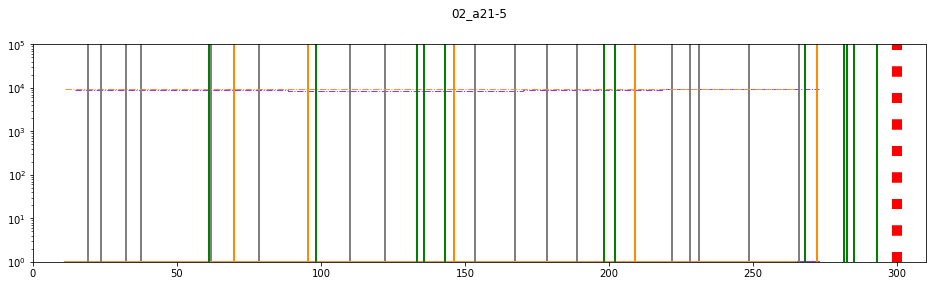

	%%% 03_t21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


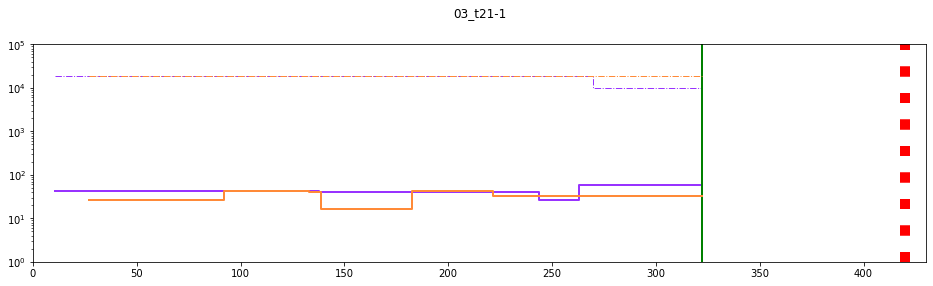

	%%% 04_v21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


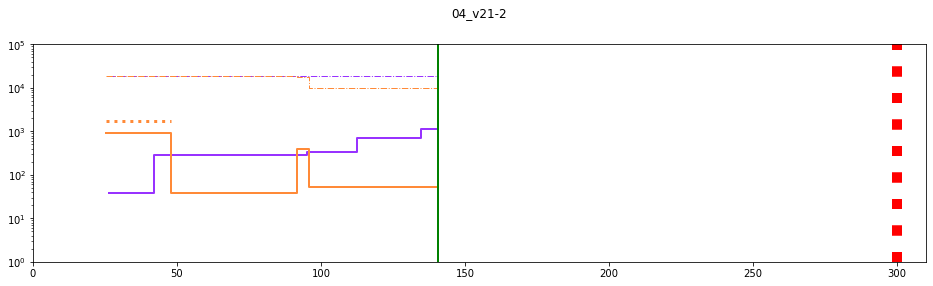

	%%% 05_a21-9 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


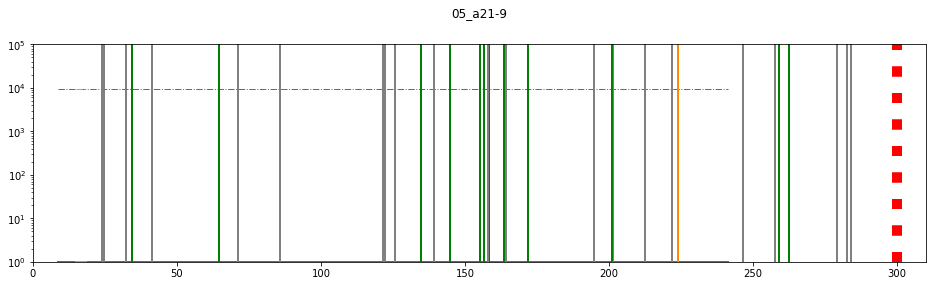

	%%% 06_t21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


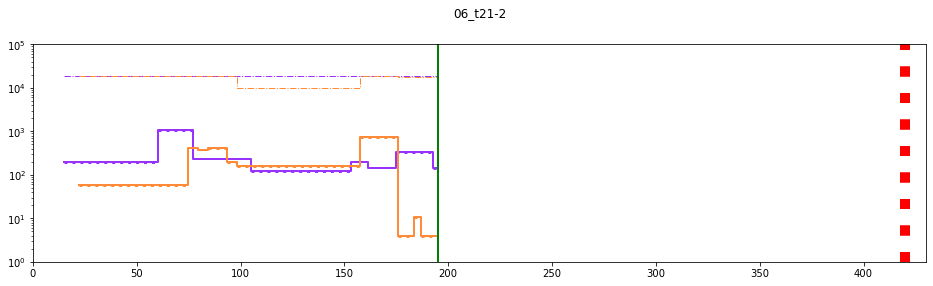

	%%% 07_v21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


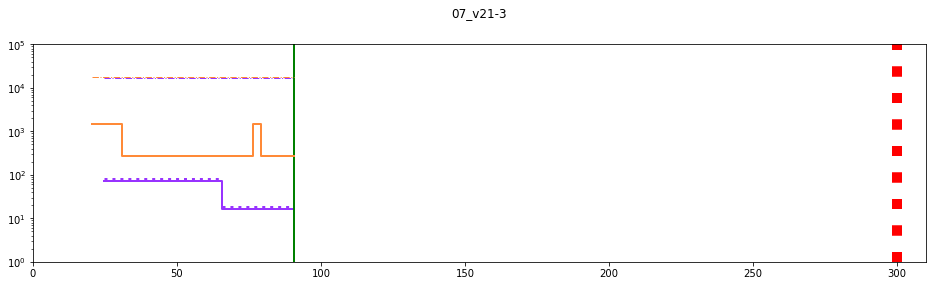

	%%% 08_t21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


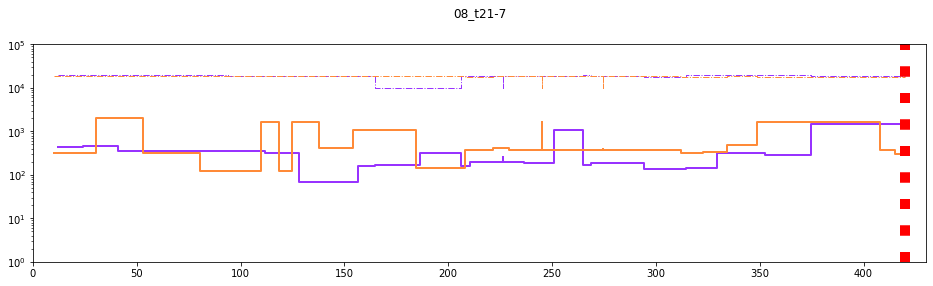

	%%% 09_a21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


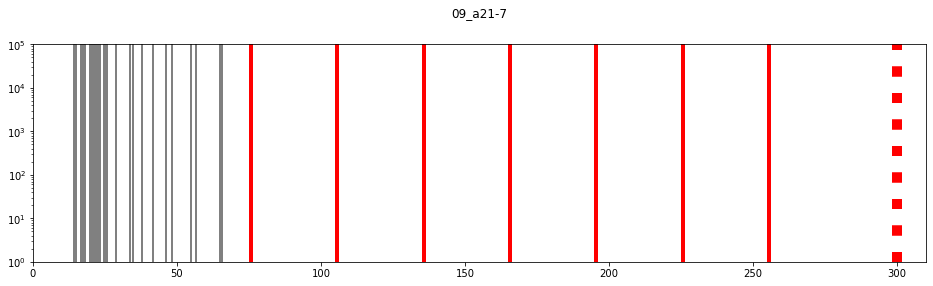

	%%% 10_a21-8 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


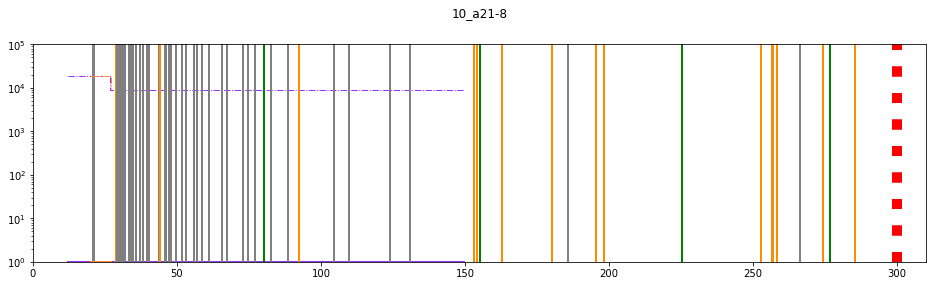

	%%% 11_v21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


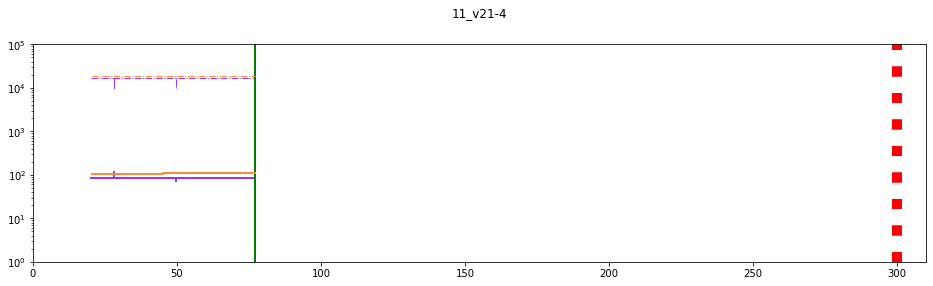

	%%% 12_t21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


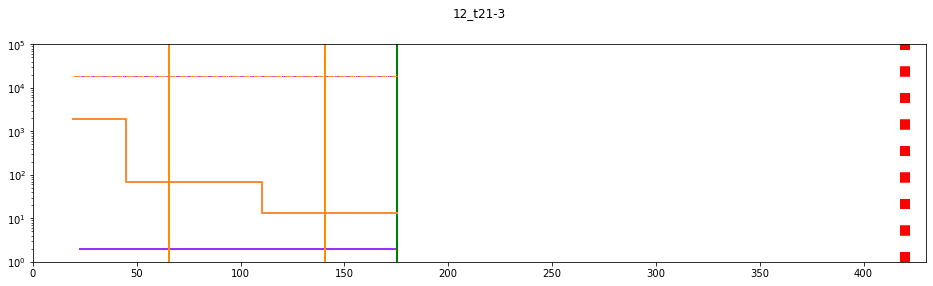

	%%% 13_a21-1 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


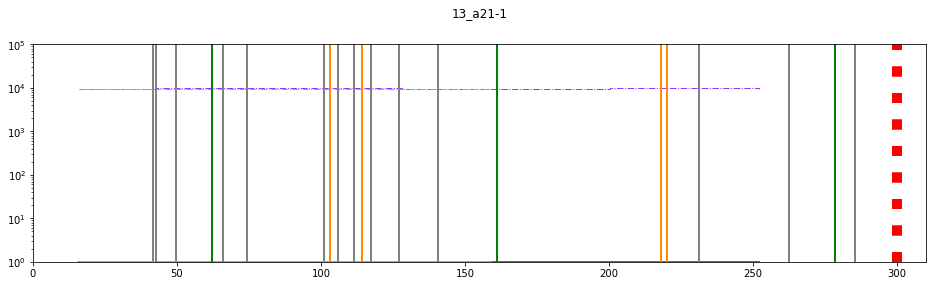

	%%% 14_t21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


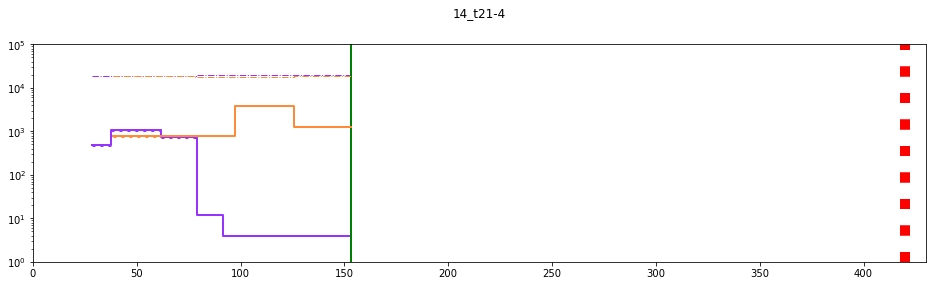

	%%% 15_v21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


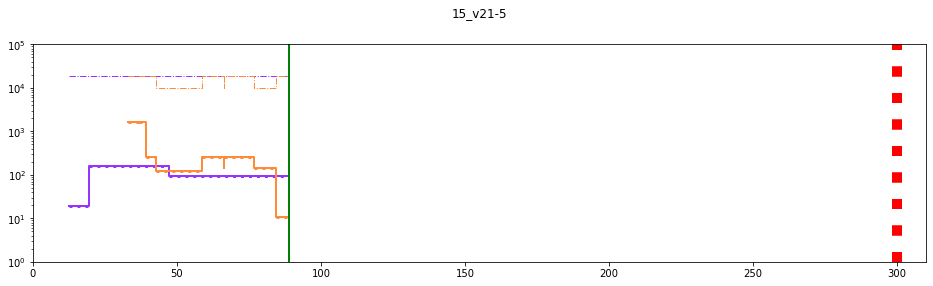

	%%% 16_t21-5 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


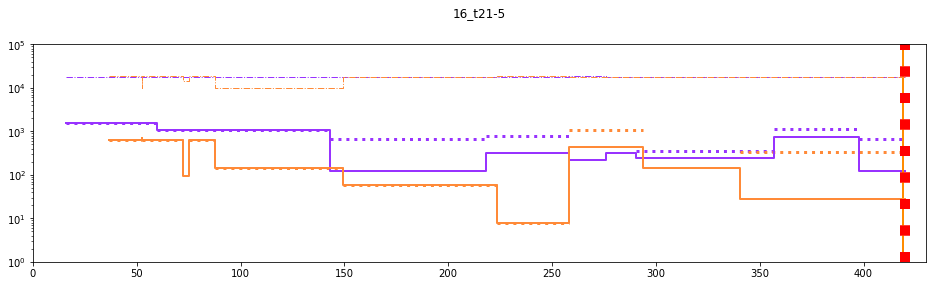

	%%% 17_v21-6 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


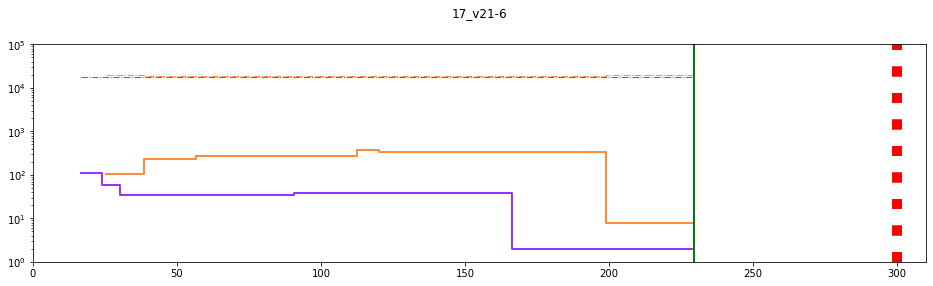

	%%% 18_v21-7 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


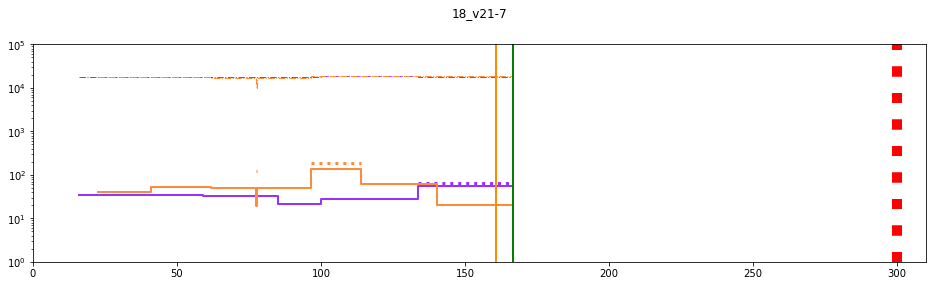

	%%% 19_a21-2 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


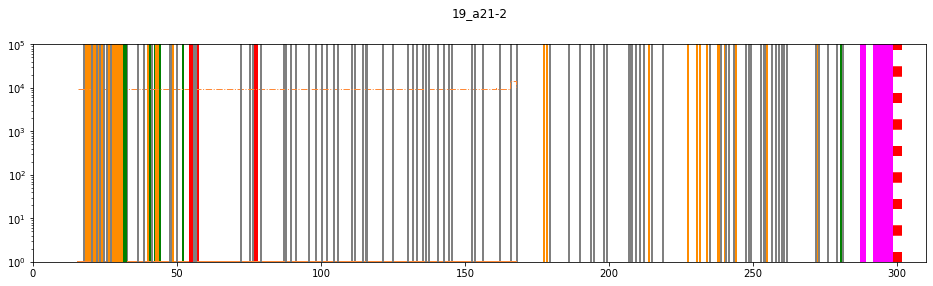

	%%% 20_v21-8 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


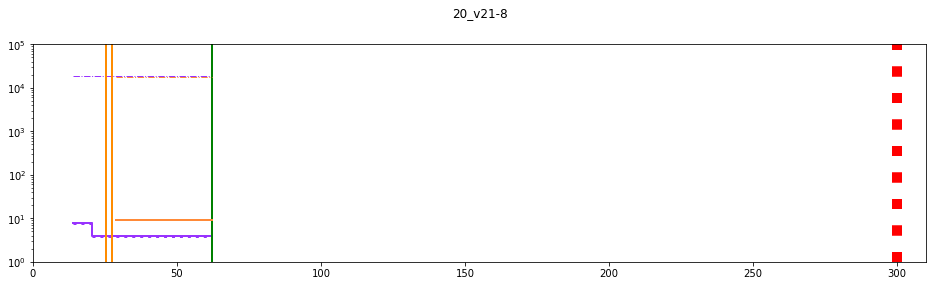

	%%% 21_v21-9 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


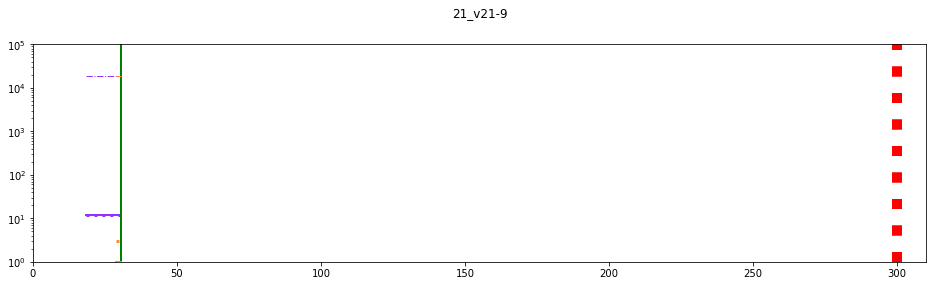

	%%% 22_v21-10 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


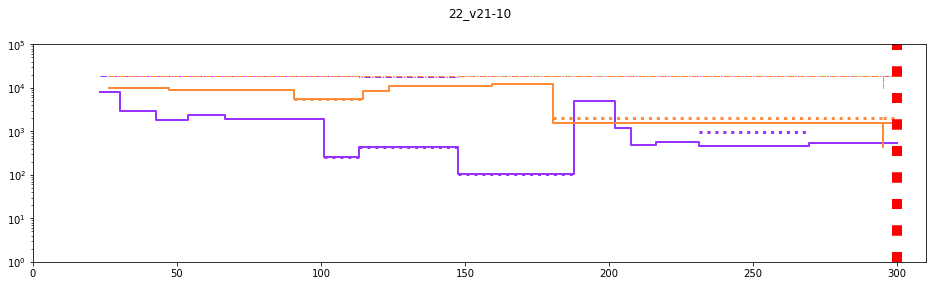

	%%% 23_v21-11 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


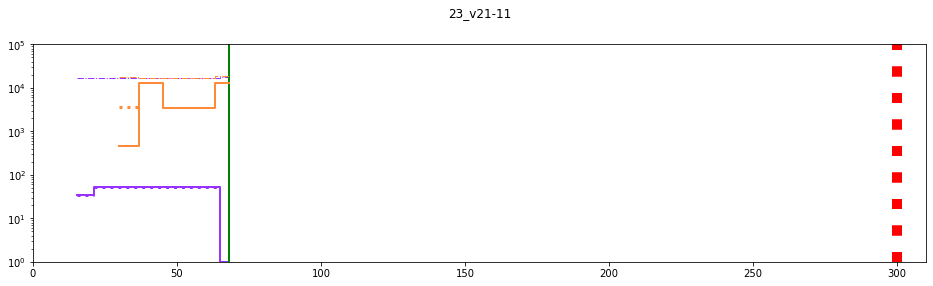

	%%% 24_v21-12 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


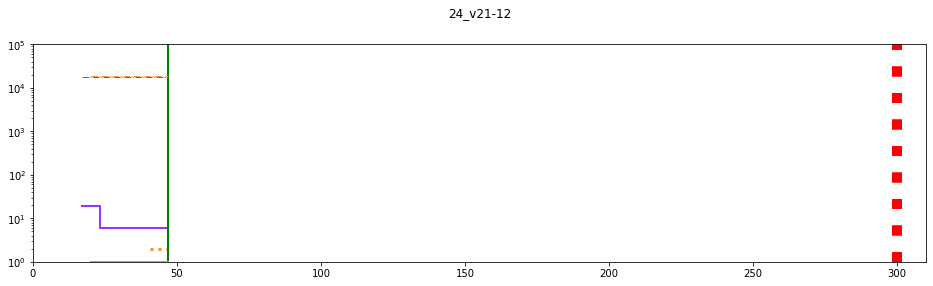

	%%% 25_v21-13 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


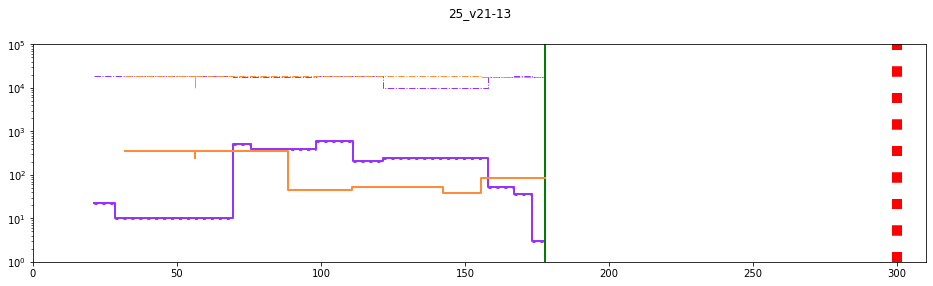

	%%% 26_a21-3 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


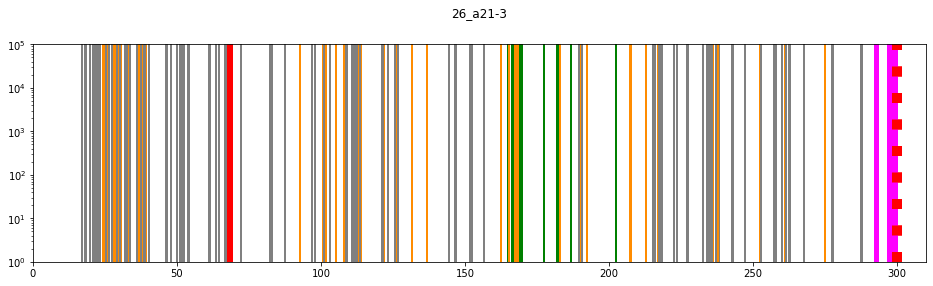

	%%% 27_v21-14 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


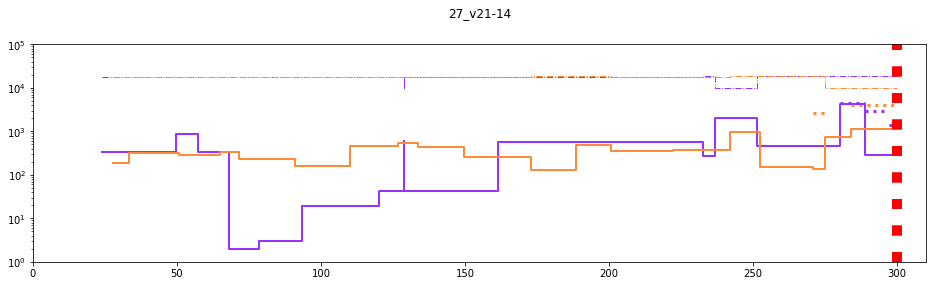

	%%% 28_a21-10 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


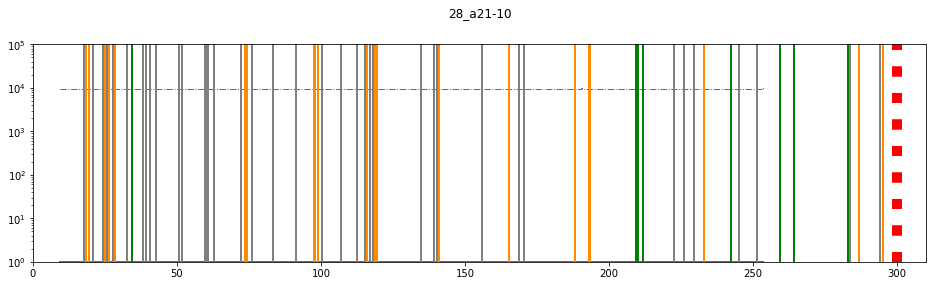

	%%% 29_v21-15 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


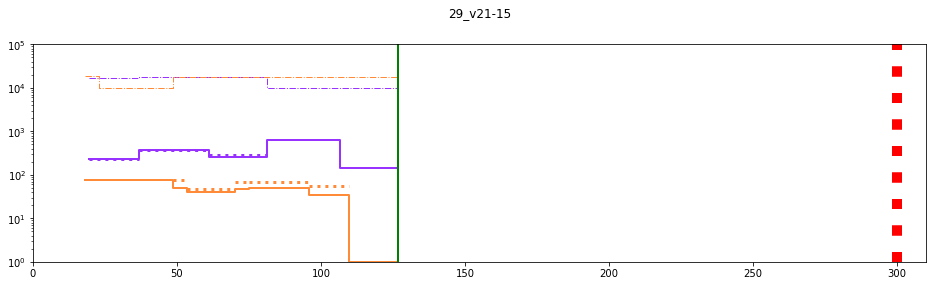

	%%% 30_a21-4 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


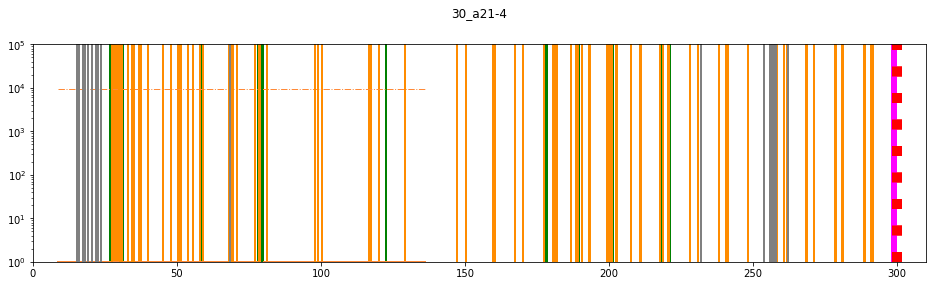

	%%% 31_v21-16 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


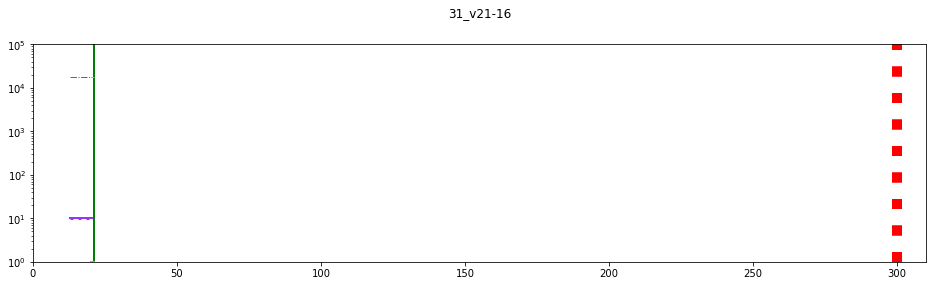

	%%% 32_v21-17 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


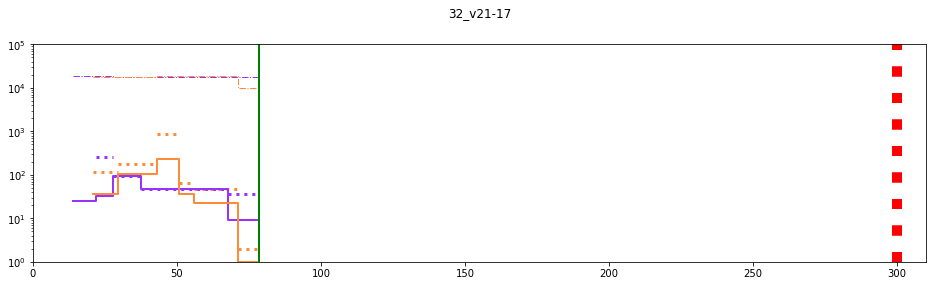

	%%% 33_a21-11 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


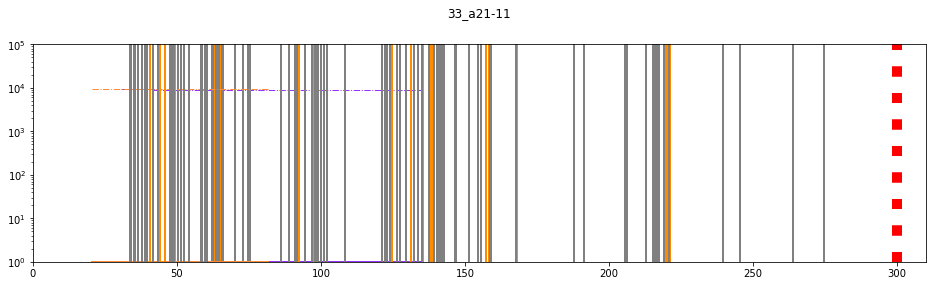

	%%% 34_v21-18 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


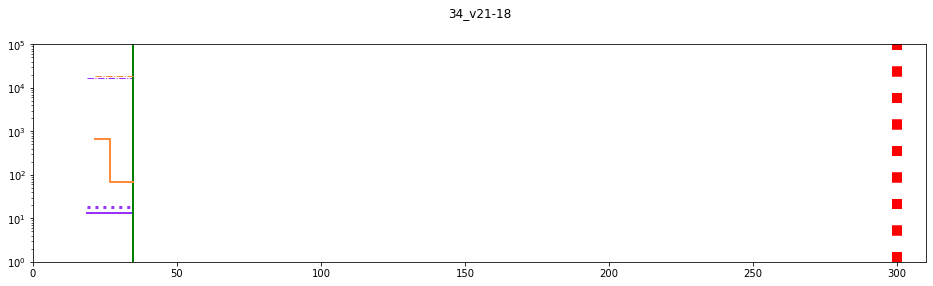

	%%% 35_v21-19 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


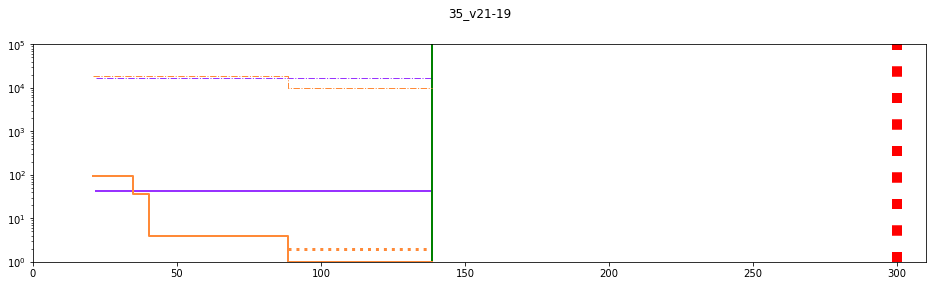

	%%% 36_v21-20 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


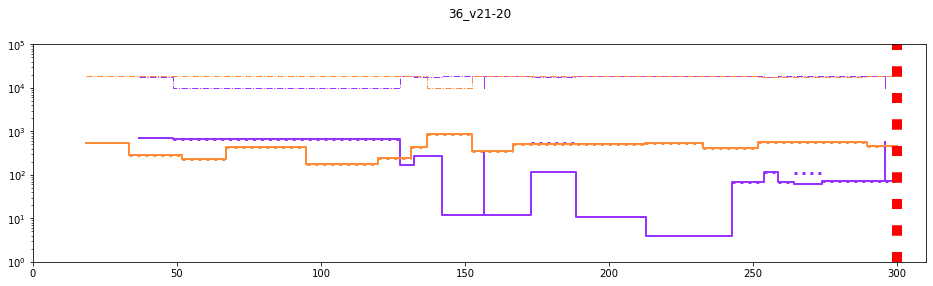

	%%% 37_a21-6 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


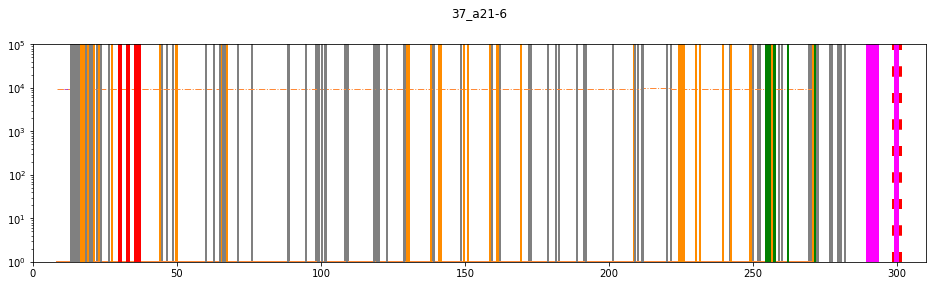

	%%% 38_v21-21 %%%
	--- SOMHunter ---
		--- sh-patrik ---
		--- sh-vit ---


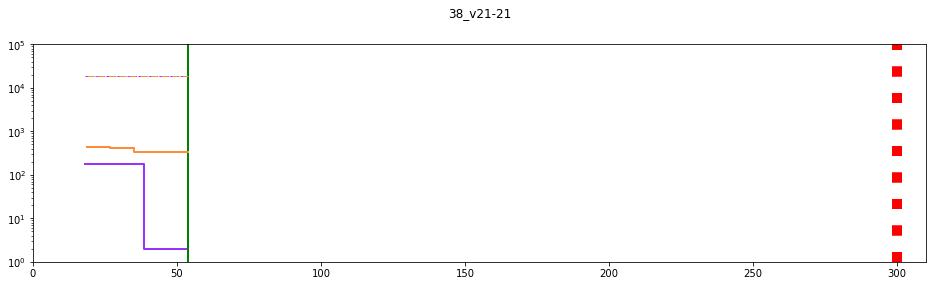

In [91]:
plot_timelines(vbs)


# Info queries

In [ ]:
vbs.print_tasks()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_tasks(["09_a21-7"])

In [ ]:
vbs.print_tool_features()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_tool_features(["SOMHunter"])

In [ ]:
vbs.print_task_results_arrays()

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

vbs.print_task_results(["SOMHunter"], ["sh-patrik", "sh-vit"], ["09_a21-7"])

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
vbs.print_task_results()

In [ ]:
#
# Print results from the given interval
#
vbs.print_results("SOMHunter", "sh-patrik", 1624281095339, 1624281395339)
vbs.print_results("SOMHunter", "sh-vit", 1624281095339, 1624281395339)


In [ ]:
#
# Print submits for each task
#
vbs.print_task_submits_arrays()
vbs.print_task_submits()